## In this project we will use different techniques analyzing copper price data as time series. 

---

# Preparations

### Import libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

plt.rcParams['figure.figsize'] = [10, 8]
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import yfinance as yf

### Create time boundaries

Creating variables with time boundaries using the datetime library.

In [7]:
import datetime

years = 10
end_date = datetime.datetime.now()
start_date = datetime.datetime.now() - datetime.timedelta(days=years*365)

### Load the data

In [9]:
ticker = "HG=F"

data = yf.download(ticker, start=start_date, end=end_date, interval='1mo')
data = data[['Adj Close']]

[*********************100%***********************]  1 of 1 completed


### Ploting function

In [11]:
def plot(x, y, title, xlabel, ylabel, grid_flg = True):
    plt.figure(figsize=(12, 6))
    plt.plot(x, y)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(grid_flg)
    
    plt.show()

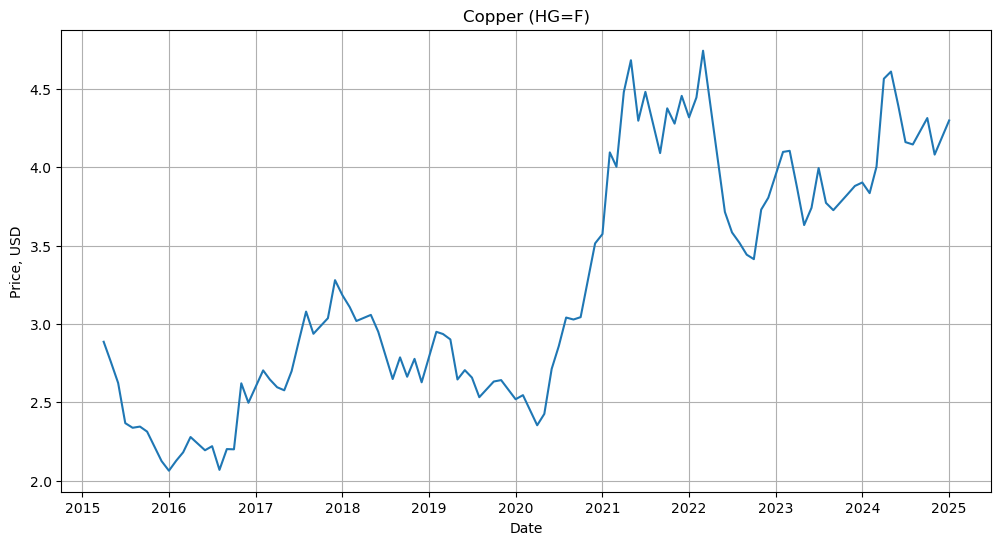

In [12]:
plot(data.index, data['Adj Close'], 'Copper (HG=F)', 'Date', 'Price, USD')

# Analysis

## Stationarity

### Differencing

In [16]:
data['Adj Close Diff'] = data['Adj Close'].diff()

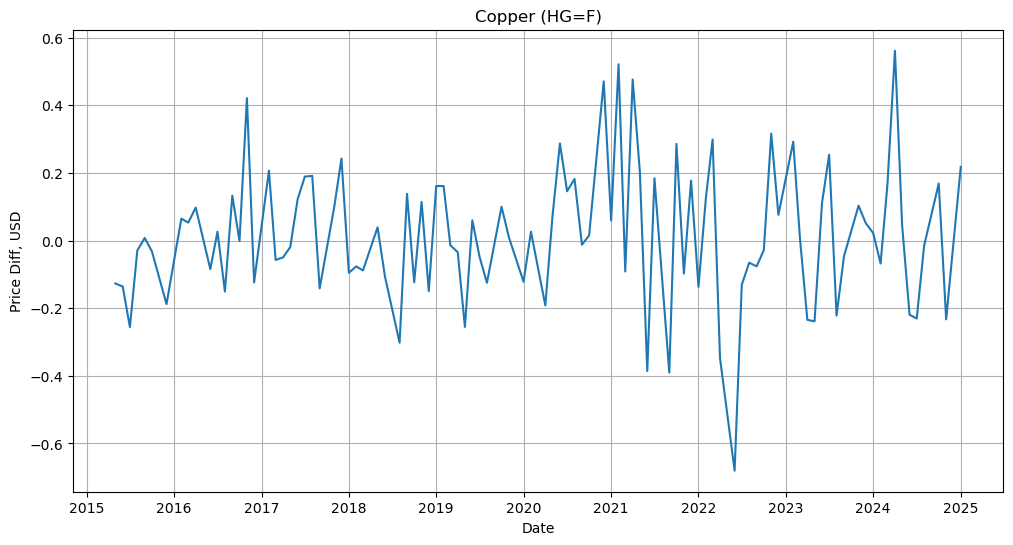

In [17]:
plot(data.index, data['Adj Close Diff'], 'Copper (HG=F)', 'Date', 'Price Diff, USD')

### ADF Test

In [19]:
def adf_test(series):
    """Using an ADF test to determine if a series is stationary"""
    test_results = adfuller(series)
    print('ADF Statistic: ', test_results[0])
    print('P-Value: ', test_results[1])
    print('Critical Values:')
    for thres, adf_stat in test_results[4].items():
        print('\t%s: %.2f' % (thres, adf_stat))

In [20]:
adf_test(data["Adj Close"][1:])

ADF Statistic:  -1.0436168895004247
P-Value:  0.73702565200499
Critical Values:
	1%: -3.50
	5%: -2.89
	10%: -2.58


The P-value for the ADF test for the original time series is pretty high. 
Definitely, tThe original series is non-stationary.

In [22]:
adf_test(data["Adj Close Diff"][1:])

ADF Statistic:  -9.889277929954227
P-Value:  3.5939081780123536e-17
Critical Values:
	1%: -3.50
	5%: -2.89
	10%: -2.58


The P-value for the ADF test for the first difference is tiny.

The first difference is stationary, meaning that differencing has removed the trend or unit root.

## Decomposition

In [25]:
data = data.dropna()

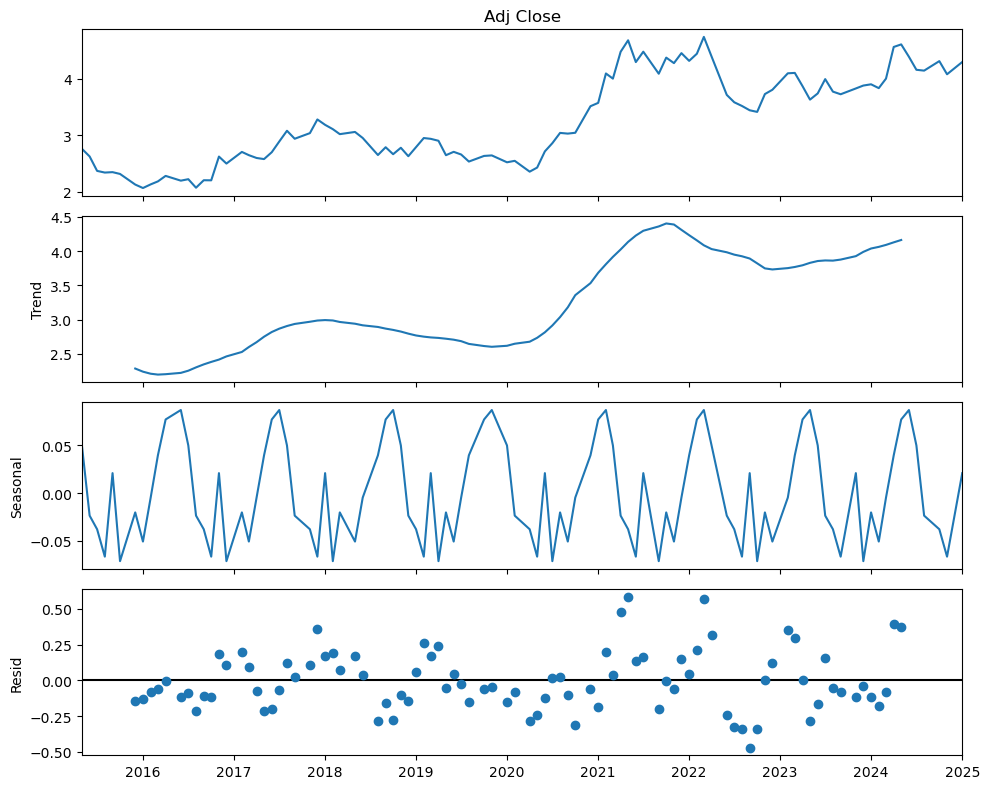

In [26]:
decomposition_plot_add = seasonal_decompose(data['Adj Close'],
                                            model='additive', period=12)
decomposition_plot_add.plot()
plt.show()

From the plot above we tried to capture the three components.

However, we can only observe that there is a solid changing trend. The seasonal component has a really small influence.

Also, we see the residuals having a higher volatility in the later years. From about 2021, the variance was higher.

## Autocorrelation (ACF)

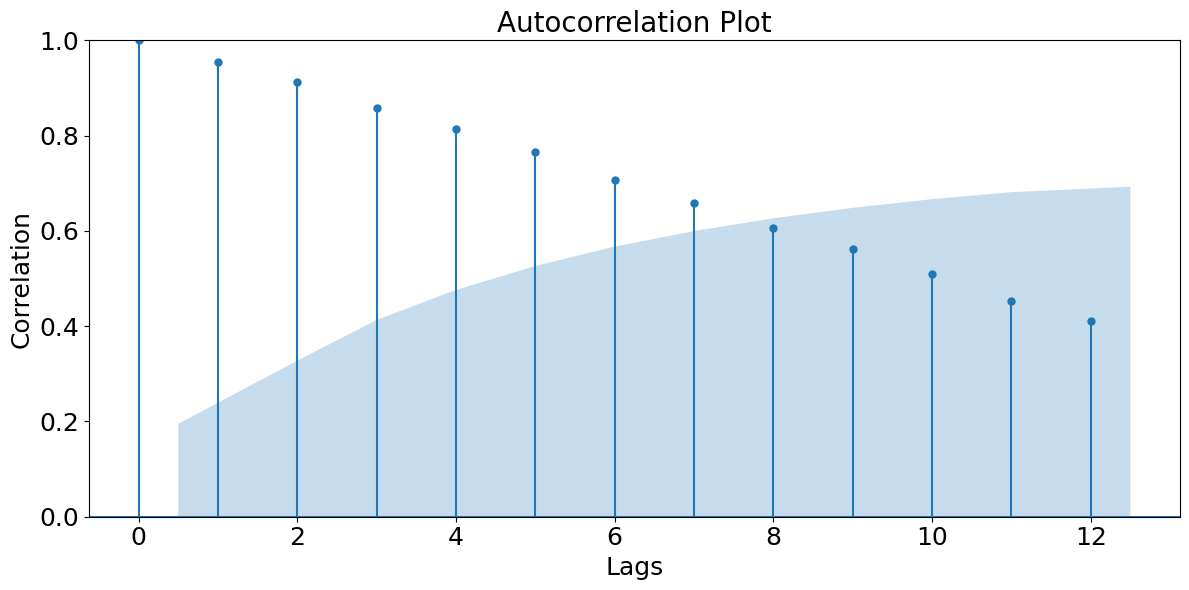

In [29]:
# Plot autocorrelation
plt.rc("figure", figsize=(12,6))
plot_acf(data['Adj Close'], lags=12)
plt.ylim(0,1)
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Correlation', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Autocorrelation Plot', fontsize=20)
plt.tight_layout()
plt.show()

We do not observe any recognizable pattern on the graph, so we can not say there is seasonality in our data.

The strength of correlation is generally and slowly decreasing as the lags increase. This points to a trend in our data, and it needs to be differenced to make it stationary when modeling.

The blue region signifies which lags are statistically significant. Therefore, when building a forecast model for this data, the next month's forecast should probably only consider __8__ of the previous values due to their statistical significance.

## Partial Autocorrelation (PACF)

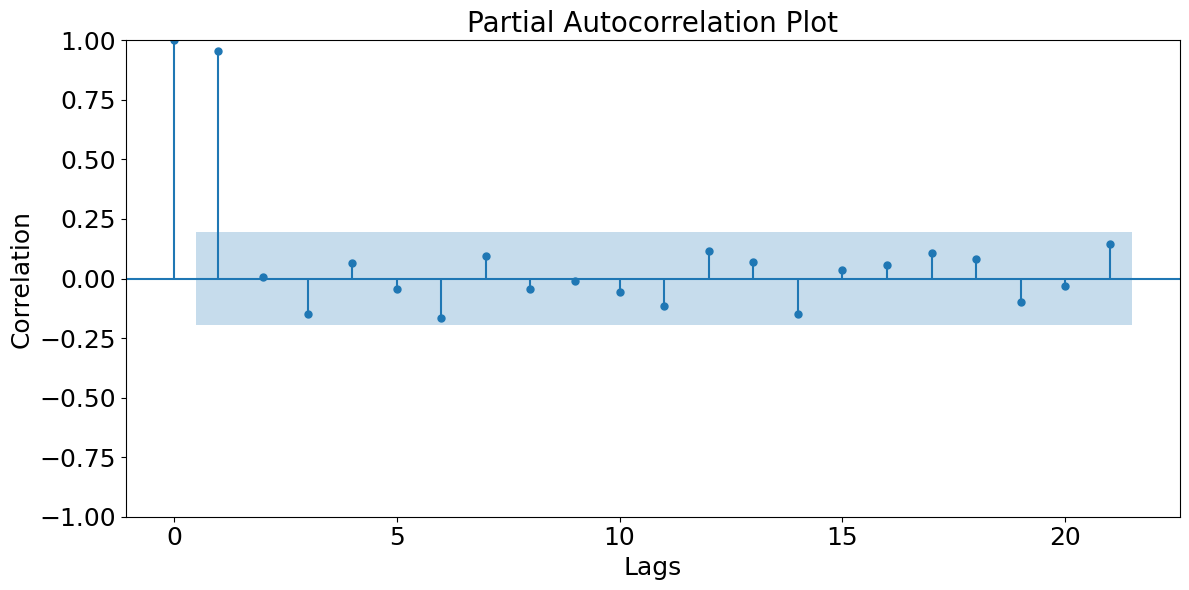

In [32]:
plt.rc("figure", figsize=(12,6))
plot_pacf(data['Adj Close'], method='ywm')
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Correlation', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Partial Autocorrelation Plot', fontsize=20)
plt.tight_layout()
plt.show()

The blue region is where lags are no longer statistically significant. We typically choose the number autoregressors by seeing how many of them are above the blue region. We see that lag __1__ is highly correlated.

# Forecasting

## Exponential Smoothing

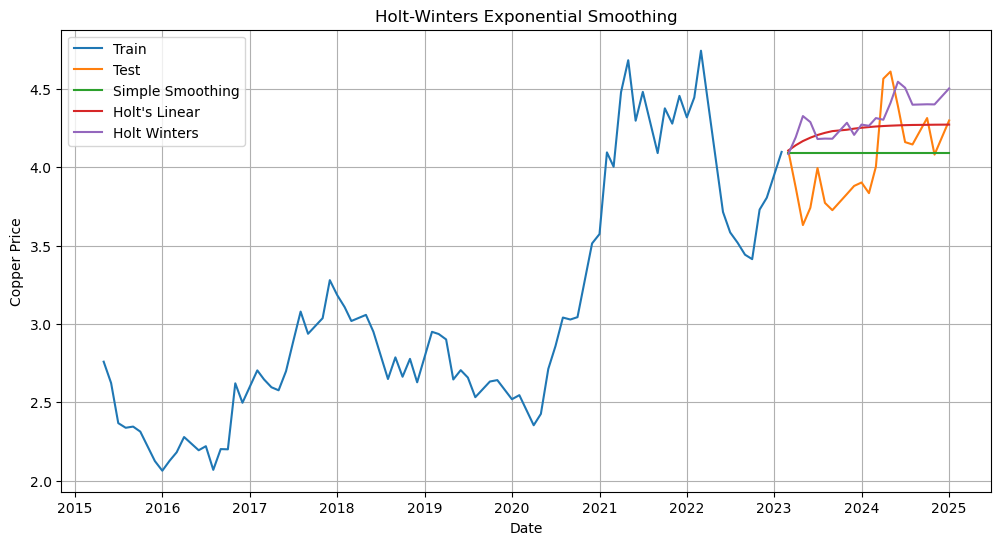

In [84]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

train = data.iloc[:-int(len(data) * 0.2)]
test = data.iloc[-int(len(data) * 0.2):]

def plot_forecasts(forecast1: list[float],
         forecast2: list[float],
         forecast3: list[float], 
         title, xlabel, ylabel, grid_flg = True):
    
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train['Adj Close'], label="Train")
    plt.plot(test.index, test['Adj Close'], label="Test")
    plt.plot(test.index, forecast1, label="Simple Smoothing")
    plt.plot(test.index, forecast2, label="Holt's Linear")
    plt.plot(test.index, forecast3, label="Holt Winters")
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(grid_flg)
    plt.legend()
    
    plt.show()


# Fit simple model and get forecasts
model_simple = SimpleExpSmoothing(train['Adj Close']).fit(optimized=True)
forecasts_simple = model_simple.forecast(len(test))

# Fit Holt's model and get forecasts
model_holt = Holt(train['Adj Close'], damped_trend=True).fit(optimized=True)
forecasts_holt = model_holt.forecast(len(test))

# Fit Holt Winters model and get forecasts
model_holt_winters = ExponentialSmoothing(train['Adj Close'], trend='mul',
                                          seasonal='add', seasonal_periods=12)\
                                          .fit(optimized=True)
forecasts_holt_winters = model_holt_winters.forecast(len(test))


# Plot the forecasts
plot_forecasts(forecasts_simple,
     forecasts_holt,
     forecasts_holt_winters,
     "Holt-Winters Exponential Smoothing", "Date", "Copper Price")

Simultaneously, we implemented three methods: Simple Exponential Smoothing, Holt’s Linear Trend Model and Holt-Winters Exponential Smoothing.

Obviously, and as we can see, the first two are not really useful for forecasting complex time series. Simple exponential smoothing behaves as Naive Forecast when we believe that the next value will be the same as the value was before. Holt’s Linear Trend Model is not really much better than the previous one though it offers us not just a straight line but a curve line.

The third approach gives a more interesting picture. We cannot say that the prediction is accurate, if at all we can say that it is at least somewhat suitable. But we can follow this line during our market decisions, we can use this line as an indicator or as a feature for ML models. However, we completely understand that there is no reason that future prices have to behave and to have the same pattern as previous prices did, because to say that this method gives us real forecasts.

## Residuals

In [105]:
train['fittedvalues'] = model_holt_winters.fittedvalues
train['residuals'] = model_holt_winters.resid

### Residual Correlation

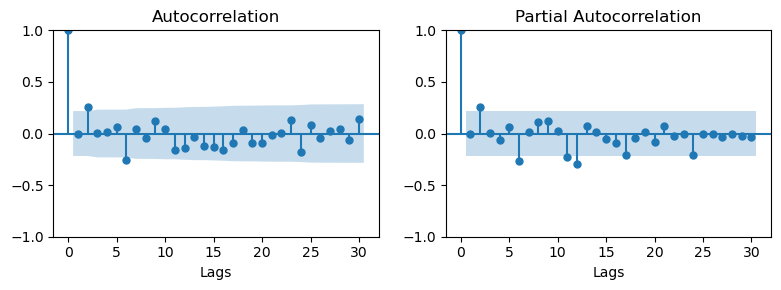

In [115]:
fig, ax = plt.subplots(1,2,figsize=(8,3))
plot_acf(train['residuals'], lags=30, ax=ax[0])
ax[0].set_xlabel('Lags')
plot_pacf(train['residuals'], lags=30, ax=ax[1])
ax[1].set_xlabel('Lags')
plt.tight_layout()
plt.show()

Most of the correlations are below the non-statistically significant level, which means the residuals are not correlated.

Also, there is no recognizable pattern in the correlations.

### Ljung-Box Test

In [100]:
print(acorr_ljungbox(train['residuals'], return_df=True))

      lb_stat  lb_pvalue
1    0.000768   0.977885
2    5.496103   0.064053
3    5.497942   0.138762
4    5.507070   0.239109
5    5.880667   0.318004
6   11.891265   0.064439
7   12.069497   0.098296
8   12.211705   0.142005
9   13.693075   0.133670
10  13.848758   0.180003


We observe the p-values of the first 10 lags. They are all above the significance level of 0.05, therefore we accept the null hypothesis of no autocorrelation.

### Histogram of Residuals

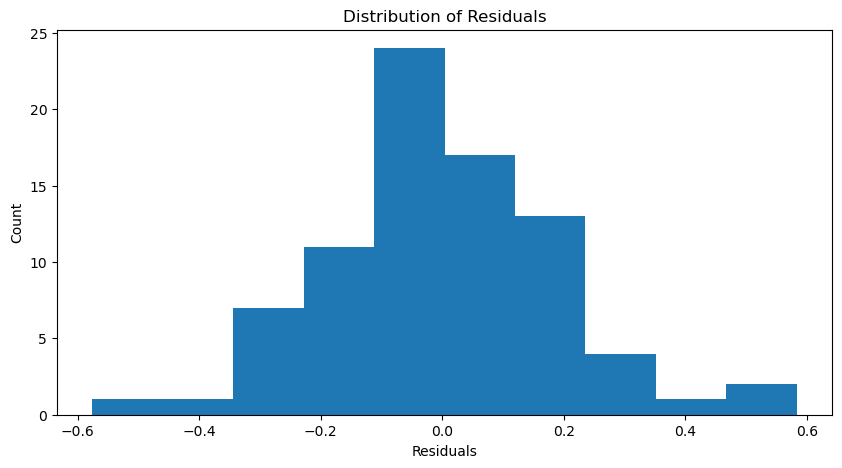

0.00015496385048539583


In [113]:
plt.figure(figsize=(10, 5))
plt.hist(train["residuals"])

plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Count")

plt.show()

print(train['residuals'].mean())

In this case, the residuals are mostly distributed around zero with a mean of 0.00015 and, though there are slight distortions, we can say that the distribution well bell-shaped.